# DOC-VQA SER Practice

This section will introduce how to use PaddleOCR to complete the training and operation of the DOC-VQA SER algorithm, including:

1. Understand the principle of DOC-VQA SER algorithm
2. Master the training process of DOC-VQA SER code in PaddleOCR

## 1 Quick Experience

Prepare code and environment

In [ ]:
# clone PaddleOCR code
# ! git clone https://github.com/PaddlePaddle/PaddleOCR

# Install dependencies
! pip install -U pip
! pip install -r /home/aistudio/PaddleOCR/requirements.txt
! pip install paddleocr

# Install dependencies
! pip install yacs gnureadline paddlenlp==2.2.1

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [ ]:
# Change to the vqa directory
import os
os.chdir('/home/aistudio/PaddleOCR/ppstructure/vqa')

In [ ]:
# Download model
! mkdir inference
# Download the detection model of the SER model and unzip it
! wget -P ./inference/ https://paddleocr.bj.bcebos.com/pplayout/PP-Layout_v1.0_ser_pretrained.tar && cd inference && tar xf PP-Layout_v1.0_ser_pretrained.tar && cd ..

--2021-12-22 16:03:11--  https://paddleocr.bj.bcebos.com/pplayout/PP-Layout_v1.0_ser_pretrained.tar
Resolving paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)... 182.61.200.195, 182.61.200.229, 2409:8c04:1001:1002:0:ff:b001:368a
Connecting to paddleocr.bj.bcebos.com (paddleocr.bj.bcebos.com)|182.61.200.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1481431040 (1.4G) [application/x-tar]
Saving to: ‘./inference/PP-Layout_v1.0_ser_pretrained.tar’

PP-Layout_v1.0_ser_ 100%[===================>]   1.38G  45.5MB/s    in 31s     

2021-12-22 16:03:42 (45.6 MB/s) - ‘./inference/PP-Layout_v1.0_ser_pretrained.tar’ saved [1481431040/1481431040]



W1226 20:10:47.258977   900 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1226 20:10:47.263010   900 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[2021/12/26 20:10:57] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.

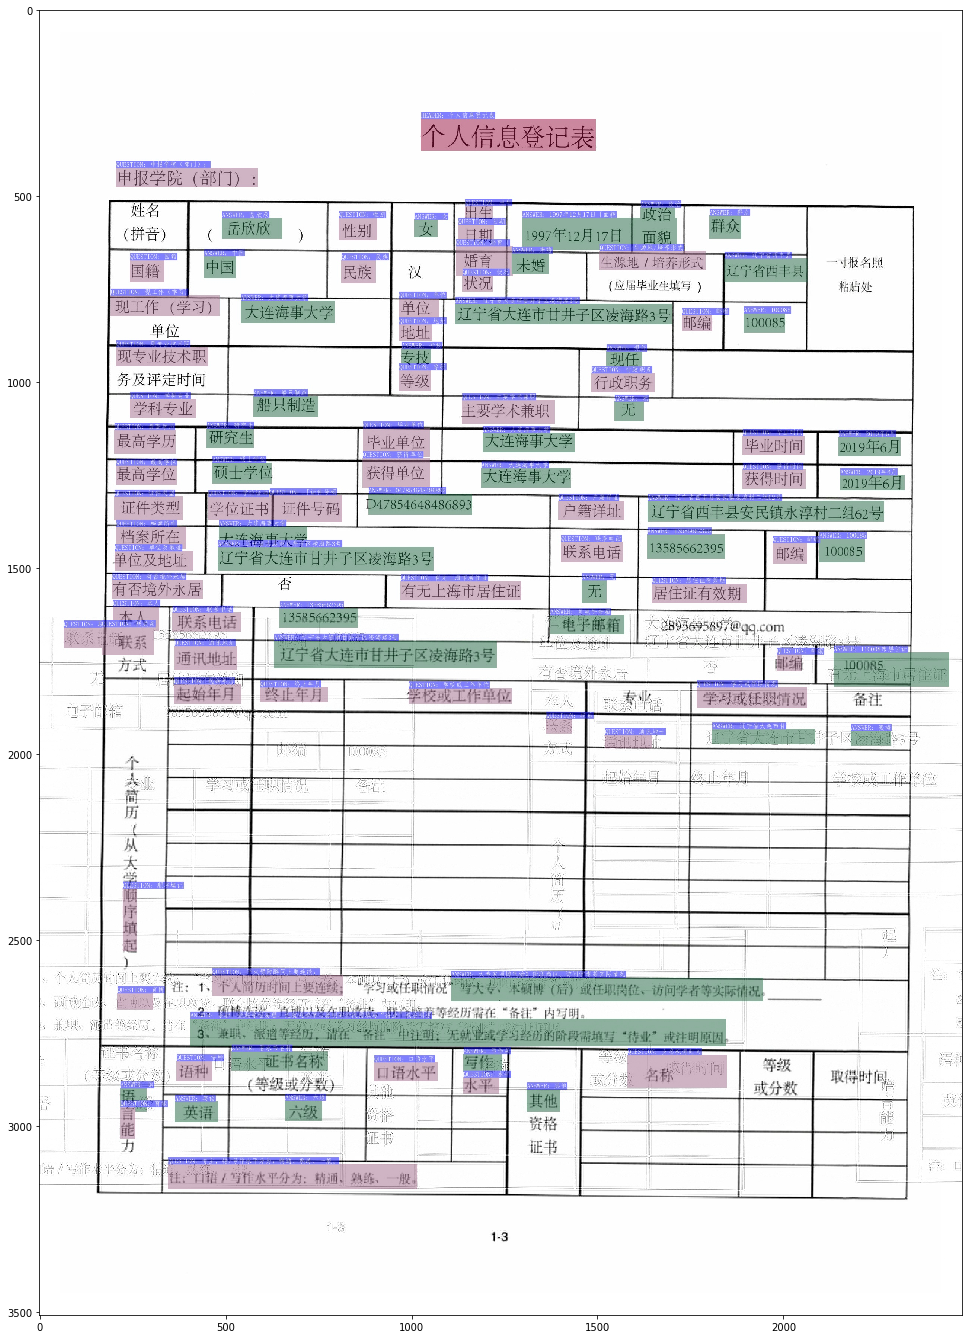

In [ ]:
# Perform SER forecast
# https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppstructure/vqa/infer_ser_e2e.py

! python infer_ser_e2e.py \
    --model_name_or_path "./inference/PP-Layout_v1.0_ser_pretrained/" \
    --max_seq_length 512 \
    --output_dir "output/res_e2e/" \
    --infer_imgs "images/input/zh_val_42.jpg"
    
import cv2
from matplotlib import pyplot as plt
# When using matplotlib.pyplot to draw in the notebook, you need to add this command to display
%matplotlib inline

img = cv2.imread('output/res_e2e/zh_val_42_ser.jpg')
plt.figure(figsize=(48,24))
plt.imshow(img)

## 2 Detailed Explanation of The Principle

The DOC-VQA series algorithms in PaddleOCR are currently implemented based on the [LayoutXLM](https://arxiv.org/pdf/2104.08836.pdf) paper, providing two tasks: SER and RE

LayoutXLM is a multi-language version of LayoutLMV2. The schematic diagram of LayoutLMV2 is as follows:
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/82762e847487489ea92ead44679bbfbed5e5d0acbcf94a3081524ce50d29f513" width="1000" ></center>
<br><center>Figure 1: LayoutLMV2 algorithm</center>

Compared with Bert in NLP, LayoutXLM adds Image and Layout information of text in the image to the input of the model. LayoutXLM has been implemented in PaddleNLP, so here we introduce the data and network from the perspective of the model forward.

### 2.1 Input Data Processing

First, perform ocr recognition or pdf analysis on the image, obtain text and bbox information, and build the three inputs of the model on this basis:

1. Text Embedding

	First, use WordPiece to segment the text recognized by OCR, then add [CLS] and [SEP] tags, and use [PAD] to fill in the length to get the text input sequence as follows:
  
   $$S=\{[CLS], w_1, w_2, \cdots , [SEP], [PAD], [PAD], \cdots \}, |S|=L$$
	
   Then add the word vector, one-dimensional position vector, and segment vector to get the text vector, the formula is as follows:
    
   $$t_i=TokEmb(w_i)+PosEmb1D(i)+SegEmb(s_i), 0 \leq i<L$$ 
    
   One-dimensional position vector: the index of the word
    
     Segmented vector: A

In [ ]:
# Text Embedding demo

from paddlenlp.transformers import LayoutXLMTokenizer

tokenizer = LayoutXLMTokenizer.from_pretrained('inference/PP-Layout_v1.0_ser_pretrained')
# Participle
print('分词结果：', tokenizer.tokenize('我的中国心'))
# Convert to index
print('转换为索引结果：', tokenizer.encode('我的中国心'))

分词结果： ['▁我', '的中国', '心']
转换为索引结果： {'input_ids': [0, 13129, 84072, 1801, 2], 'token_type_ids': [0, 0, 0, 0, 0]}


2. Image Embedding

	We use the ResNeXt-FPN network as the image encoder, first extract the feature map of the original document image, then average it into a fixed size (B * 256 * 7 * 7), and then expand the average pooled feature map by row (B * 256 * 49), after linear projection (B * 49 * 256), the characteristic sequence corresponding to the image can be obtained. Corresponding to the composition of the text vector, the image vector is also supplemented with one-dimensional relative position and segmentation information. Finally, add the feature vector, one-dimensional position vector, and segment vector to get the final image vector, as shown below:
    
 	$$v_i=Proj(VisTokEmb(I)_i)+PosEmb1D(i)+SegEmb([C]), 0 \leq i<WH$$
    
    Segmented vector：C
3. Layout Embedding

	Corresponding to the coordinate range covered by each word or image area on the page, a bounding box parallel to the coordinate axis is used to represent the layout information, and each bounding box is represented by 4 boundary coordinate values, width, and height. The final layout vector is obtained by concatenating the vectors corresponding to the 6 features:
    
   $$I_i=Concat(PosEmb2D_x(x_0, x_1, w), PosEmb2D_y(y_0, y_1, h)), 0 \leq i<WH+L$$
   

The following demonstrates the process of constructing a network input from an input image in the prediction process. The whole process mainly includes the following steps

1. Perform OCR recognition on the image
2. Preprocess the image, including scaling to a specified size and normalization
3. Segment and index the recognized text
4. Normalize the text box so that its value is between 0-1000
5. Pad the results after processing 3 and 4 to facilitate batch grouping

In [ ]:
# Predictive input construction
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppstructure/vqa/vqa_utils.py

import cv2
import numpy as np
import paddle
from copy import deepcopy
from paddleocr import PaddleOCR
from paddlenlp.transformers import LayoutXLMTokenizer

from infer_ser_e2e import trans_poly_to_bbox,pad_sentences,split_page

def parse_ocr_info_for_ser(ocr_result):
    # The ocr result is converted to dictionary form, and the text box is converted to a bounding rectangle
    ocr_info = []
    for res in ocr_result:
        ocr_info.append({
            "text": res[1][0],
            "bbox": trans_poly_to_bbox(res[0]),
            "poly": res[0],
        })
    return ocr_info

def preprocess(
        tokenizer,
        ori_img,
        ocr_info,
        img_size=(224, 224),
        pad_token_label_id=-100,
        max_seq_len=512,
        add_special_ids=False,
        return_attention_mask=True, ):
    ocr_info = deepcopy(ocr_info)
    height = ori_img.shape[0]
    width = ori_img.shape[1]
    
    # Resize the image to the specified shape
    img = cv2.resize(ori_img, img_size).transpose([2, 0, 1]).astype(np.float32)
    
    segment_offset_id = [] # Stores the ending position of each text in input_ids
    bbox_list = [] # Store a box normalized to 0-1000
    input_ids_list = [] # Store the index of the text segment after the word segmentation in the vocabulary
    token_type_ids_list = [] # Store the category information of the text segment

    for info in ocr_info:
        # box Normalized to 0-1000
        # x1, y1, x2, y2
        bbox = info["bbox"]
        bbox[0] = int(bbox[0] * 1000.0 / width)
        bbox[2] = int(bbox[2] * 1000.0 / width)
        bbox[1] = int(bbox[1] * 1000.0 / height)
        bbox[3] = int(bbox[3] * 1000.0 / height)
        
        # Tokenizer the text information, including word segmentation and conversion to the index in the vocabulary
        text = info["text"]
        encode_res = tokenizer.encode(
            text, pad_to_max_seq_len=False, return_attention_mask=True)
        
        # Decide whether to delete special characters according to the parameters
        if not add_special_ids:
            # TODO: use tok.all_special_ids to remove
            encode_res["input_ids"] = encode_res["input_ids"][1:-1]
            encode_res["token_type_ids"] = encode_res["token_type_ids"][1:-1]
            encode_res["attention_mask"] = encode_res["attention_mask"][1:-1]

        input_ids_list.extend(encode_res["input_ids"])
        token_type_ids_list.extend(encode_res["token_type_ids"])
        bbox_list.extend([bbox] * len(encode_res["input_ids"]))
        segment_offset_id.append(len(input_ids_list))

    encoded_inputs = {
        "input_ids": input_ids_list,
        "token_type_ids": token_type_ids_list,
        "bbox": bbox_list,
        "attention_mask": [1] * len(input_ids_list),
    }
    # Val pad to the specified length, and 0 to supplement the length that is not enough
    encoded_inputs = pad_sentences(
        tokenizer,
        encoded_inputs,
        max_seq_len=max_seq_len,
        return_attention_mask=return_attention_mask)
    
   # input_ids> 512, divided into 2 batches
    ncoded_inputs = split_page(encoded_inputs)

    fake_bs = encoded_inputs["input_ids"].shape[0]

    encoded_inputs["image"] = paddle.to_tensor(img).unsqueeze(0).expand(
        [fake_bs] + list(img.shape))

    encoded_inputs["segment_offset_id"] = segment_offset_id

    return encoded_inputs

img = cv2.imread('images/input/zh_val_42.jpg')

ocr_engine = PaddleOCR(use_angle_cls=False,show_log=False)
# Perform ocr recognition
ocr_result = ocr_engine.ocr(img, cls=False)
# ocr The result is converted to dictionary form, and the text box is converted to a bounding rectangle
ocr_info = parse_ocr_info_for_ser(ocr_result)


tokenizer = LayoutXLMTokenizer.from_pretrained('inference/PP-Layout_v1.0_ser_pretrained')
# Resize the image,
# Perform word segmentation on the text, convert it to dictionary index and other operations,
# Normalize the box
max_seq_length = 512
inputs = preprocess(tokenizer=tokenizer,ori_img=img,ocr_info=ocr_info,max_seq_len=max_seq_length, img_size=(224,224))

print(inputs.keys())
print(inputs['image'].shape)

[2021/12/26 20:11:19] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pg

Corrupt JPEG data: premature end of data segment


dict_keys(['input_ids', 'token_type_ids', 'bbox', 'attention_mask', 'image', 'segment_offset_id'])
[2, 3, 224, 224]


The processed data is a dictionary containing the following fields:
<center>
  
| Field | Meaning |
|---|---|
|image| Image resize 224*224 |
|bbox| Box normalized to 0-1000 |
|input_ids| The index of the text segment after the text has been segmented in the vocabulary |
|token_type_ids| Category information of the text segment|
|attention_mask| Mask the text segment, the corresponding position of the special character is marked as 0, and the corresponding position of the text segment is marked as 1. |
|segment_offset_id| Record the ending position of each text in input_ids|
  
<center/>

### 2.2 SER Network

SER: Semantic Entity Recognition, which can recognize and classify text in images.
A fully connected classification header is added to the output of the SER network LayoutXLMModel, and the network code is as follows:

In [ ]:
# https://github.com/PaddlePaddle/PaddleNLP/blob/develop/paddlenlp/transformers/layoutxlm/modeling.py#L846

from paddlenlp.transformers import LayoutXLMPretrainedModel
from paddle import nn
class LayoutXLMForTokenClassification(LayoutXLMPretrainedModel):
    def __init__(self, layoutxlm, num_classes=2, dropout=None):
        super(LayoutXLMForTokenClassification, self).__init__()
        self.num_classes = num_classes
        if isinstance(layoutxlm, dict):
            self.layoutxlm = LayoutXLMModel(**layoutxlm)
        else:
            self.layoutxlm = layoutxlm
        self.dropout = nn.Dropout(dropout if dropout is not None else self.layoutxlm.config["hidden_dropout_prob"])
        self.classifier = nn.Linear(self.layoutxlm.config["hidden_size"],num_classes)
        self.classifier.apply(self.init_weights)

    def get_input_embeddings(self):
        return self.layoutxlm.embeddings.word_embeddings

    def forward(self, input_ids=None, bbox=None, image=None, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None, labels=None):
        # backbone Calculation
        outputs = self.layoutxlm(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, token_type_ids=token_type_ids, position_ids=position_ids, head_mask=head_mask)
        seq_length = input_ids.shape[1]
        # head Calculation
        sequence_output, image_output = outputs[0][:, :seq_length], outputs[0][:, seq_length:]
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        outputs = logits,
        
        # Calculation loss
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()

            if attention_mask is not None:
                active_loss = attention_mask.reshape([-1, ]) == 1
                active_logits = logits.reshape([-1, self.num_classes])[active_loss]
                active_labels = labels.reshape([-1, ])[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.reshape([-1, self.num_classes]),labels.reshape([-1, ]))
            outputs = (loss, ) + outputs
        return outputs

In [ ]:
# Initialize the network
net = LayoutXLMForTokenClassification.from_pretrained('inference/PP-Layout_v1.0_ser_pretrained')
net.eval()
# Perform network forward
outputs = net(input_ids=inputs["input_ids"],
            bbox=inputs["bbox"],
            image=inputs["image"],
            token_type_ids=inputs["token_type_ids"],
            attention_mask=inputs["attention_mask"])
print(outputs[0].shape)

[2, 512, 7]


### 2.3 Post-Processing

Post-processing mainly completes the correspondence between the predicted results of the text output of the model and the text, and combines the results with the results of OCR, mainly including the following steps

1. For each text, count the predicted labels of all text segments under the text
2. Select the label with the most predictions of all text segments as the label of the text

In [ ]:
# https://github.com/PaddlePaddle/PaddleOCR/blob/release/2.4/ppstructure/vqa/vqa_utils.py

import paddle
import numpy as np

from infer_ser_e2e import get_bio_label_maps

label2id_map, id2label_map = get_bio_label_maps('labels/labels_ser.txt')

def postprocess(attention_mask, preds, id2label_map):
    if isinstance(preds, paddle.Tensor):
        preds = preds.numpy()
    preds = np.argmax(preds, axis=2)

    preds_list = [[] for _ in range(preds.shape[0])]

    # keep batch info
    for i in range(preds.shape[0]):
        for j in range(preds.shape[1]):
            if attention_mask[i][j] == 1:
                preds_list[i].append(id2label_map[preds[i][j]])

    return preds_list

def merge_preds_list_with_ocr_info(ocr_info, segment_offset_id, preds_list,
                                   label2id_map_for_draw):
    # list flatten
    preds = [p for pred in preds_list for p in pred]
    
    # The dictionary of label2idx is converted to the field of idx2label, and the prefixes of B- and I- are removed
    id2label_map = dict()
    for key in label2id_map_for_draw:
        val = label2id_map_for_draw[key]
        if key == "O":
            id2label_map[val] = key
        if key.startswith("B-") or key.startswith("I-"):
            id2label_map[val] = key[2:]
        else:
            id2label_map[val] = key
    print("id2label_map:",id2label_map)
    
    # For each text, count the predicted label
    for idx in range(len(segment_offset_id)):
        if idx == 0:
            start_id = 0
        else:
            start_id = segment_offset_id[idx - 1]
    
        end_id = segment_offset_id[idx]
        # Take out the range of text in the output
        curr_pred = preds[start_id:end_id]
        # Take out all the prediction results of the text in the output
        curr_pred = [label2id_map_for_draw[p] for p in curr_pred]

        if len(curr_pred) <= 0:
            pred_id = 0
        else:
            # print("pred label:",curr_pred)
            # Count label
            counts = np.bincount(curr_pred)
            # print("counts:",counts)
            pred_id = np.argmax(counts)
        ocr_info[idx]["pred_id"] = int(pred_id)
        ocr_info[idx]["pred"] = id2label_map[int(pred_id)]
        # print("pred label:",id2label_map[int(pred_id)])
    return ocr_info

preds = postprocess(inputs["attention_mask"], outputs[0], id2label_map)

# Replace the value label at the beginning of I with the value label at the beginning of B
label2id_map_for_draw = dict()
for key in label2id_map:
    if key.startswith("I-"):
        label2id_map_for_draw[key] = label2id_map["B" + key[1:]]
    else:
        label2id_map_for_draw[key] = label2id_map[key]
print("label2id_map:",label2id_map)
print("label2id_map_for_draw:",label2id_map_for_draw)
# Combine forecast information and ocr information
ocr_info_with_ser = merge_preds_list_with_ocr_info(ocr_info, inputs["segment_offset_id"], preds, label2id_map_for_draw)
print(ocr_info_with_ser)

label2id_map: {'O': 0, 'B-QUESTION': 1, 'I-QUESTION': 2, 'B-ANSWER': 3, 'I-ANSWER': 4, 'B-HEADER': 5, 'I-HEADER': 6}
label2id_map_for_draw: {'O': 0, 'B-QUESTION': 1, 'I-QUESTION': 1, 'B-ANSWER': 3, 'I-ANSWER': 3, 'B-HEADER': 5, 'I-HEADER': 5}
id2label_map: {0: 'O', 1: 'QUESTION', 3: 'ANSWER', 5: 'HEADER'}
[{'text': '个人信息登记表', 'bbox': [1026.0, 292.0, 1495.0, 377.0], 'poly': [[1027.0, 292.0], [1495.0, 300.0], [1494.0, 377.0], [1026.0, 369.0]], 'pred_id': 5, 'pred': 'HEADER'}, {'text': '申报学院（部门）：', 'bbox': [207.0, 424.0, 587.0, 475.0], 'poly': [[207.0, 424.0], [587.0, 424.0], [587.0, 475.0], [207.0, 475.0]], 'pred_id': 1, 'pred': 'QUESTION'}, {'text': '出生', 'bbox': [1144.0, 526.0, 1218.0, 566.0], 'poly': [[1144.0, 526.0], [1218.0, 526.0], [1218.0, 566.0], [1144.0, 566.0]], 'pred_id': 1, 'pred': 'QUESTION'}, {'text': '政治', 'bbox': [1616.0, 530.0, 1709.0, 570.0], 'poly': [[1616.0, 530.0], [1709.0, 530.0], [1709.0, 570.0], [1616.0, 570.0]], 'pred_id': 3, 'pred': 'ANSWER'}, {'text': '1997年12月

## 3 Training


This section takes the XFUN Chinese data set as an example to introduce how to complete the training, evaluation and testing of the SER model.

### 3.1 Data Preparation

Here, the [XFUN](https://github.com/doc-analysis/XFUND) dataset is used as the experimental dataset.
The XFUN data set is a multilingual data set for KIE tasks proposed by Microsoft. It contains a total of seven data sets, each of which contains 149 training sets and 50 validation sets.

* ZH (Chinese)
* JA (Japanese)
* ES (Spain)
* FR (French)
* IT (Italy)
* DE (German)
* PT (Portugal)

This experiment selects the Chinese data set as our demonstration data set. The French data set is used as a data set for practical courses. The sample data set is shown in the figure below


<center><img src="https://ai-studio-static-online.cdn.bcebos.com/0f84137778cd4ab6899c64109d452290e9c678ccf01744978bc9c0647adbba45" width="1000" ></center>
<br><center>Figure 2: Sample data set, left Chinese, right French</center>


You can run the following commands to complete the download and decompression of the Chinese data set, or from [https://github.com/doc-analysis/XFUND](https://github.com/doc-analysis/XFUND) Download by yourself。

In [ ]:
! wget https://paddleocr.bj.bcebos.com/dataset/XFUND.tar
! tar -xf XFUND.tar

#XFUN other data sets use the following code to convert
# https://github.com/PaddlePaddle/PaddleOCR/blob/release%2F2.4/ppstructure/vqa/helper/trans_xfun_data.py

File ‘XFUND.tar’ already there; not retrieving.



After running the above command, there are 2 folders in the /home/aistudio/PaddleOCR/ppstructure/vqa/XFUND directory, and the directory structure is as follows:

```bash
/home/aistudio/PaddleOCR/ppstructure/vqa/XFUND
   └─ zh_train/ training set
       ├── image/ image storage folder
       ├── xfun_normalize_train.json label information
   └─ zh_val/ verification set
       ├── image/ image storage folder
       ├── xfun_normalize_val.json label information

```

The label format of this dataset is

```bash
{
    "height": 3508, # Image height
    "width": 2480,  # Image width
    "ocr_info": [
        {
            "text": "邮政地址:",  # Single text content
            "label": "question", # The category of the text
            "bbox": [261, 802, 483, 859], # Single text box
            "id": 54,  # Text Index
            "linking": [[54, 60]], # The relationship between the current text and other texts [question, answer]
            "words": []
        },
        {
            "text": "湖南省怀化市市辖区",
            "label": "answer",
            "bbox": [487, 810, 862, 859],
            "id": 60,
            "linking": [[54, 60]],
            "words": []
        }
    ]
}
```

### 3.2 Loss Function Definition

Because it is a multi-classification task, loss uses CrossEntropyLoss

### 3.3 Model Training

After completing the data processing and loss function definition, you can start training the model.

The specific training commands are as follows:

In [7]:
! python train_ser.py \
    --model_name_or_path "layoutxlm-base-uncased" \
    --ser_model_type "LayoutXLM" \
    --train_data_dir "XFUND/zh_train/image" \
    --train_label_path "XFUND/zh_train/xfun_normalize_train.json" \
    --eval_data_dir "XFUND/zh_val/image" \
    --eval_label_path "XFUND/zh_val/xfun_normalize_val.json" \
    --per_gpu_train_batch_size 8 \
    --per_gpu_eval_batch_size 8 \
    --num_train_epochs 200 \
    --eval_steps 10 \
    --output_dir "./output/ser/" \
    --learning_rate 5e-5 \
    --warmup_steps 50 \
    --evaluate_during_training \
    --num_workers 0 \
    --seed 2048

[2021/12/26 20:12:07] root INFO: -----------  Configuration Arguments -----------
[2021/12/26 20:12:07] root INFO: adam_epsilon: 1e-08
[2021/12/26 20:12:07] root INFO: det_model_dir: None
[2021/12/26 20:12:07] root INFO: eval_data_dir: XFUND/zh_val/image
[2021/12/26 20:12:07] root INFO: eval_label_path: XFUND/zh_val/xfun_normalize_val.json
[2021/12/26 20:12:07] root INFO: eval_steps: 10
[2021/12/26 20:12:07] root INFO: evaluate_during_training: True
[2021/12/26 20:12:07] root INFO: infer_imgs: None
[2021/12/26 20:12:07] root INFO: label_map_path: ./labels/labels_ser.txt
[2021/12/26 20:12:07] root INFO: learning_rate: 5e-05
[2021/12/26 20:12:07] root INFO: max_grad_norm: 1.0
[2021/12/26 20:12:07] root INFO: max_seq_length: 512
[2021/12/26 20:12:07] root INFO: model_name_or_path: layoutxlm-base-uncased
[2021/12/26 20:12:07] root INFO: num_train_epochs: 200
[2021/12/26 20:12:07] root INFO: num_workers: 0
[2021/12/26 20:12:07] root INFO: ocr_json_path: None
[2021/12/26 20:12:07] root INFO:

### 3.4 Model Evaluation

During the training process, two models are saved by default, one is the latest trained model named latest, and the other is the most accurate model named best. The folder structure for saving the model is as follows
```bash
output/ser/
├── best_model
│ ├── model_config.json # Model configuration
│ ├── model_state.pdparams # Model parameters
│ ├── sentencepiece.bpe.model # Parameters of tokenizer
│ ├── tokenizer_config.json # tokenizer configuration
│ └── training_args.bin # Parameters when starting training
├── infer_results.txt
├── latest_model
│   ├── model_config.json
│   ├── model_state.pdparams
│   ├── sentencepiece.bpe.model
│   ├── tokenizer_config.json
│   └── training_args.bin
├── test_gt.txt
├── test_pred.txt
└── train.log  # Training log
```

Next, use the saved model parameters to evaluate the accuracy on the test set:

In [ ]:
! python eval_ser.py \
    --model_name_or_path "output/ser/best_model" \
    --ser_model_type "LayoutXLM" \
    --eval_data_dir "XFUND/zh_val/image" \
    --eval_label_path "XFUND/zh_val/xfun_normalize_val.json" \
    --per_gpu_eval_batch_size 8 \
    --num_workers 8 \
    --output_dir "output/ser/"  \
    --seed 2048

[2021/12/26 20:13:05] root INFO: -----------  Configuration Arguments -----------
[2021/12/26 20:13:05] root INFO: adam_epsilon: 1e-08
[2021/12/26 20:13:05] root INFO: det_model_dir: None
[2021/12/26 20:13:05] root INFO: eval_data_dir: XFUND/zh_val/image
[2021/12/26 20:13:05] root INFO: eval_label_path: XFUND/zh_val/xfun_normalize_val.json
[2021/12/26 20:13:05] root INFO: eval_steps: 10
[2021/12/26 20:13:05] root INFO: evaluate_during_training: False
[2021/12/26 20:13:05] root INFO: infer_imgs: None
[2021/12/26 20:13:05] root INFO: label_map_path: ./labels/labels_ser.txt
[2021/12/26 20:13:05] root INFO: learning_rate: 5e-05
[2021/12/26 20:13:05] root INFO: max_grad_norm: 1.0
[2021/12/26 20:13:05] root INFO: max_seq_length: 512
[2021/12/26 20:13:05] root INFO: model_name_or_path: output/ser/best_model
[2021/12/26 20:13:05] root INFO: num_train_epochs: 3
[2021/12/26 20:13:05] root INFO: num_workers: 8
[2021/12/26 20:13:05] root INFO: ocr_json_path: None
[2021/12/26 20:13:05] root INFO: o

#### 3.5 Model Prediction

After training the model, you can also use the saved model to perform model inference on a single picture or an image in a folder, and observe the prediction effect of the model.

In [ ]:
! python infer_ser_e2e.py \
    --model_name_or_path "./inference/PP-Layout_v1.0_ser_pretrained/" \
    --ser_model_type "LayoutXLM" \
    --max_seq_length 512 \
    --output_dir "output/ser_e2e/" \
    --infer_imgs "images/input/zh_val_42.jpg"

W1226 20:07:23.831934   640 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1226 20:07:23.835953   640 device_context.cc:465] device: 0, cuDNN Version: 7.6.
[2021/12/26 20:07:33] root WARNING: version PP-OCRv2 not support cls models, auto switch to version PP-OCR
Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/aistudio/.paddleocr/2.3.0.2/ocr/det/ch/ch_PP-OCRv2_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='box', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.

## 4 Assignment

Experimental questions

[https://aistudio.baidu.com/aistudio/projectdetail/3281385](https://aistudio.baidu.com/aistudio/projectdetail/3281385)
